<a href="https://colab.research.google.com/github/RainiBenaiah/Data-Preprocessing/blob/main/data_preprocessing/datapreprocessing_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing

## Part One: Data Cleaning and Data Augmentation

### I.  Data Cleaning

In [ ]:
# IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from datetime import timedelta
from sklearn.feature_extraction.text import TfidfVectorizer
import random

In [ ]:
# LOAD DATA (customer_transaction.csv) AND CREATE COPIES FOR DIFFERENT IMPUTATIONS

path = '/content/drive/MyDrive/customer_transactions.csv'
data = pd.read_csv(path)
print(data.head(10))

# create copies for the different imputation techniques
for i in range (1, 3):
  copied_file = f'copy_{i}.csv'
  data.to_csv(copied_file, index=False)
  print(f'saved {copied_file}')

   customer_id_legacy  transaction_id  purchase_amount purchase_date  \
0                 151            1001              408    2024-01-01   
1                 192            1002              332    2024-01-02   
2                 114            1003              442    2024-01-03   
3                 171            1004              256    2024-01-04   
4                 160            1005               64    2024-01-05   
5                 120            1006              395    2024-01-06   
6                 182            1007               91    2024-01-07   
7                 186            1008              429    2024-01-08   
8                 174            1009              228    2024-01-09   
9                 174            1010              112    2024-01-10   

  product_category  customer_rating  
0           Sports              2.3  
1      Electronics              4.2  
2      Electronics              2.1  
3         Clothing              2.8  
4         Clothin

In [ ]:
# FIND MISSING VALUES

missing_values = data.isnull().sum()
print(missing_values)

customer_id_legacy     0
transaction_id         0
purchase_amount        0
purchase_date          0
product_category       0
customer_rating       10
dtype: int64


- The ***'customer_rating'*** column is the only column with missing values.

- The missing values will be imputed with *Median Imputation*

- We will also use the other copy we created to impute the missing data with predictive modeling with *Random Forest*



In [ ]:
copy_path = 'copy_1.csv'
data_i = pd.read_csv(copy_path)
print(data_i.head(3))

   customer_id_legacy  transaction_id  purchase_amount purchase_date  \
0                 151            1001              408    2024-01-01   
1                 192            1002              332    2024-01-02   
2                 114            1003              442    2024-01-03   

  product_category  customer_rating  
0           Sports              2.3  
1      Electronics              4.2  
2      Electronics              2.1  


In [ ]:
# MEDIAN IMPUTATION

# only the customer ratings column has misssing values

missing_ratings = data_i[data_i['customer_rating'].isna()]

# function to fill customer ratings based on past customer ratings

def fill_rating(row):
  if pd.isna(row['customer_rating']):# processing only missing values
    # get past ratings for the same customer
    past_ratings = data_i[data_i['customer_id_legacy'] == row['customer_id_legacy']]['customer_rating'].dropna()


    if not past_ratings.empty:
      return past_ratings.median()

    else:
      # if no previous ratings, fall back to product category median
      category_median = data_i[data_i['product_category'] == row['product_category']]['customer_rating'].median()
      return category_median if not pd.isna(category_median) else data_i['customer_rating'].median()

  return row['customer_rating']

data_i['customer_rating'] = data_i.apply(fill_rating, axis=1)

print(data_i['customer_rating'].isna().sum())

0


In [ ]:
copy_path = 'copy_2.csv'
data_ii = pd.read_csv(copy_path)
print(data_ii.head(3))

   customer_id_legacy  transaction_id  purchase_amount purchase_date  \
0                 151            1001              408    2024-01-01   
1                 192            1002              332    2024-01-02   
2                 114            1003              442    2024-01-03   

  product_category  customer_rating  
0           Sports              2.3  
1      Electronics              4.2  
2      Electronics              2.1  


In [ ]:
# PREDICTIVE MODELING IMPUTATION WITH RANDOM FOREST

# experimenting with predictive modeling usin RandomForest
complete_data = data_ii.dropna(subset=['customer_rating'])

# encode product category
complete_data['product_category'] = LabelEncoder().fit_transform(complete_data['product_category'])

# define features and target variable
X = complete_data.drop(columns=['customer_rating', 'customer_id_legacy', 'transaction_id', 'purchase_date'])
y = complete_data['customer_rating']

# split data into train and test
X_train_eval, X_test_eval, y_train_eval, y_test_eval = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# train model
model_eval = RandomForestRegressor(n_estimators=100, random_state=42)
model_eval.fit(X_train_eval, y_train_eval)

# predict missing customer ratings
y_pred_eval = model_eval.predict(X_test_eval)

# evaluate model
rmse = np.sqrt(mean_squared_error(y_test_eval, y_pred_eval))
r2 = r2_score(y_test_eval, y_pred_eval)

print(f'RMSE: {rmse:.4f}')
print(f'R² Score: {r2:.4f}')

RMSE: 1.5229
R² Score: -0.4782


We will proceed with data augmentation with the copy we imputed its missing values using median

### II. Data Augmentation

**1.   Applying Random Noise to Numerical Transaction Values**



In [ ]:
# define noise level (1-5% of the mean transaction amount)

noise_std = 0.05 * data_i['purchase_amount'].mean()
data_i['purchase_amount_aug'] = data_i['purchase_amount'] + np.random.normal(0, noise_std, data_i.shape[0])

**2. Synthetic Data Generation (New Transactions per Customer)**

In [ ]:
def generate_synthetic_transactions(data_i, num_new=75):
    new_data = []
    for _ in range(num_new):
        row = data_i.sample(1).iloc[0].copy()
        row['transaction_id'] = data_i['transaction_id'].max() + random.randint(1, 100)
        row['purchase_amount'] += np.random.normal(0, noise_std)
        row['purchase_date'] = pd.to_datetime(row['purchase_date']) + timedelta(days=random.randint(1, 30))
        new_data.append(row)

    return pd.DataFrame(new_data)

# generate 75 synthetic transactions
synthetic_data = generate_synthetic_transactions(data_i, num_new=75)

# duplicate 75 real transactions
real_duplicates = data_i.sample(75, replace=True).copy()
real_duplicates['transaction_id'] = real_duplicates['transaction_id'].max() + np.arange(1, 76)

# combine all data
data_augmented = pd.concat([data_i, synthetic_data, real_duplicates], ignore_index=True)

data_augmented.shape

(300, 7)

Now that the dataset is augmented, (doubled the number of rows), we will save our dataset to use it for merging

In [ ]:
# saving and exporting augmented dataset

augmented_data = data_augmented
output_file = 'customer_transactions_augmented.csv'
augmented_data.to_csv(output_file, index=False)

print(f'saved the dataset as {output_file}')

saved the dataset as customer_transactions_augmented.csv




---



## Part Two: Merging Datasets with Transitive Properties

We will be merging our saved ***customer_transactions_augmented.csv***  with ***id_mapping.csv*** and ***customer_social_profiles.csv***

### I. Merge transactions with ID mapping

In [ ]:
# LOAD DATA

transactions = pd.read_csv("customer_transactions_augmented.csv")
id_mapping = pd.read_csv("/content/drive/MyDrive/id_mapping.csv")

# MERGE TRANSACTIONS WITH ID MAPPING

merged_data = transactions.merge(id_mapping, on="customer_id_legacy", how="left")

# Check merge success
print(merged_data.head())
print(f"Missing customer_id_new: {merged_data['customer_id_new'].isna().sum()}")


   customer_id_legacy  transaction_id  purchase_amount purchase_date  \
0                 151            1001            408.0    2024-01-01   
1                 192            1002            332.0    2024-01-02   
2                 192            1002            332.0    2024-01-02   
3                 192            1002            332.0    2024-01-02   
4                 192            1002            332.0    2024-01-02   

  product_category  customer_rating  purchase_amount_aug customer_id_new  
0           Sports              2.3           413.195463            A176  
1      Electronics              4.2           323.370777            A156  
2      Electronics              4.2           323.370777            A108  
3      Electronics              4.2           323.370777            A110  
4      Electronics              4.2           323.370777            A140  
Missing customer_id_new: 65


In [ ]:
# Find customer_id_legacy values in transactions that do NOT exist in id_mapping.csv
unmatched_legacy_ids = merged_data[merged_data['customer_id_new'].isna()]['customer_id_legacy'].unique()

print(f"Total unique customer_id_legacy missing in id_mapping.csv: {len(unmatched_legacy_ids)}")
print("Sample of missing customer_id_legacy values:", unmatched_legacy_ids[:10])


Total unique customer_id_legacy missing in id_mapping.csv: 16
Sample of missing customer_id_legacy values: [171 160 123 102 148 154 172 117 108 143]


We will assign '*unlinked* '  to missing customer_id_new

In [ ]:
merged_data['customer_id_new'] = merged_data['customer_id_new'].fillna("unlinked")

### II. Merge with customer_social_profiles.csv

In [ ]:
customer_social_profiles = pd.read_csv("/content/drive/MyDrive/customer_social_profiles.csv")

In [ ]:
# Count unique customer_id_new in both datasets before merging
print("Unique customer_id_new in merged_data:", merged_data['customer_id_new'].nunique())
print("Unique customer_id_new in customer_social_profiles:", customer_social_profiles['customer_id_new'].nunique())

# Check how many customer_id_new are missing in customer_social_profiles
missing_customer_new = merged_data[~merged_data['customer_id_new'].isin(customer_social_profiles['customer_id_new'])]
print("Transactions with customer_id_new not in social profiles:", missing_customer_new.shape[0])


Unique customer_id_new in merged_data: 66
Unique customer_id_new in customer_social_profiles: 84
Transactions with customer_id_new not in social profiles: 154


In [ ]:
# MERGE merged_data WITH customer_social_profiles

final_merged_data = merged_data.merge(customer_social_profiles, on="customer_id_new", how="left")

# check the impact of merging
print("Rows in final_merged_data:", final_merged_data.shape[0])
print("Columns in final_merged_data:", final_merged_data.columns)


Rows in final_merged_data: 758
Columns in final_merged_data: Index(['customer_id_legacy', 'transaction_id', 'purchase_amount',
       'purchase_date', 'product_category', 'customer_rating',
       'purchase_amount_aug', 'customer_id_new', 'social_media_platform',
       'engagement_score', 'purchase_interest_score', 'review_sentiment'],
      dtype='object')


In [ ]:
# Recheck missing values in each column
print(final_merged_data.isna().sum())


customer_id_legacy           0
transaction_id               0
purchase_amount              0
purchase_date                0
product_category             0
customer_rating              0
purchase_amount_aug          0
customer_id_new              0
social_media_platform      154
engagement_score           154
purchase_interest_score    154
review_sentiment           154
dtype: int64


#### Handling the missing values

**Imputation Plan:**

- social_media_platform : Replace NaN with "Unknown"

- engagement_score : Replace NaN with 0 (assume inactive users)

- purchase_interest_score : Replace NaN with the mean of the column

- review_sentiment : Replace NaN with "Neutral"

In [ ]:
# filling missing values
final_merged_data["social_media_platform"] = final_merged_data["social_media_platform"].fillna("Unknown")
final_merged_data["engagement_score"] = final_merged_data["engagement_score"].fillna(0)
final_merged_data["purchase_interest_score"] = final_merged_data["purchase_interest_score"].fillna(final_merged_data["purchase_interest_score"].mean())
final_merged_data["review_sentiment"] = final_merged_data["review_sentiment"].fillna("Neutral")

# check no missing values remain
print(final_merged_data.isna().sum())


customer_id_legacy         0
transaction_id             0
purchase_amount            0
purchase_date              0
product_category           0
customer_rating            0
purchase_amount_aug        0
customer_id_new            0
social_media_platform      0
engagement_score           0
purchase_interest_score    0
review_sentiment           0
dtype: int64


### III. Feature Engineering and Transformation

#### Compute Customer Engagement Score

In [ ]:
# normalize values
scaler = MinMaxScaler()
final_merged_data[['purchase_amount_aug', 'engagement_score', 'purchase_interest_score']] = scaler.fit_transform(
    final_merged_data[['purchase_amount_aug', 'engagement_score', 'purchase_interest_score']]
)

# compute customer engagement score
final_merged_data["customer_engagement_score"] = (
    final_merged_data["purchase_amount_aug"] * 0.33 +
    final_merged_data["engagement_score"] * 0.33 +
    final_merged_data["purchase_interest_score"] * 0.34
)

# preview
print(final_merged_data[["customer_id_new", "customer_engagement_score"]].head())


  customer_id_new  customer_engagement_score
0            A176                   0.686504
1            A156                   0.698156
2            A108                   0.380407
3            A110                   0.380407
4            A140                   0.658489


#### Compute Moving Averages for Purchases

In [ ]:
# 1. PURCHASE DATES
# strip any trailing spaces and remove time component if present
final_merged_data["purchase_date"] = (
    final_merged_data["purchase_date"].astype(str).str.strip().str.split().str[0]
)

# safely convert to datetime
final_merged_data["purchase_date"] = pd.to_datetime(final_merged_data["purchase_date"], errors="coerce")

# Check if any invalid dates remain
print("Missing/Invalid Dates:", final_merged_data["purchase_date"].isna().sum())

final_merged_data["purchase_date"] = pd.to_datetime(final_merged_data["purchase_date"])

# Sort by customer and date
final_merged_data = final_merged_data.sort_values(by=["customer_id_new", "purchase_date"])

# 2. ROLLING AVERAGES
# Compute rolling averages per customer
final_merged_data["rolling_avg_3"] = (
    final_merged_data.groupby("customer_id_new")["purchase_amount_aug"]
    .transform(lambda x: x.rolling(window=3, min_periods=1).mean())
)

final_merged_data["rolling_avg_5"] = (
    final_merged_data.groupby("customer_id_new")["purchase_amount_aug"]
    .transform(lambda x: x.rolling(window=5, min_periods=1).mean())
)

# Count total transactions per customer
final_merged_data["total_purchases"] = final_merged_data.groupby("customer_id_new")["transaction_id"].transform("count")

# Preview
print(final_merged_data[["customer_id_new", "purchase_amount_aug", "rolling_avg_3", "rolling_avg_5", "total_purchases"]].head(10))


Missing/Invalid Dates: 0
    customer_id_new  purchase_amount_aug  rolling_avg_3  rolling_avg_5  \
71             A101             0.375875       0.375875       0.375875   
134            A101             1.000000       0.687938       0.687938   
114            A102             0.090399       0.090399       0.090399   
742            A102             0.090399       0.090399       0.090399   
137            A102             0.743732       0.308177       0.308177   
458            A102             0.090399       0.308177       0.253732   
172            A102             0.912394       0.582175       0.385465   
509            A102             0.743732       0.582175       0.516131   
323            A102             0.455736       0.703954       0.589199   
705            A102             0.455736       0.551735       0.531600   

     total_purchases  
71                 2  
134                2  
114                8  
742                8  
137                8  
458                8  

#### TF-IDF on customer reviews or social media comments

In [ ]:
print(final_merged_data["review_sentiment"].value_counts())

review_sentiment
Neutral     334
Positive    231
Negative    193
Name: count, dtype: int64


**Let's first transform the sentiments into texts**

In [ ]:
# Define mapping
sentiment_map = {
    "Positive": "good excellent happy satisfied amazing",
    "Negative": "bad terrible disappointed unhappy poor",
    "Neutral": "okay neutral average fine normal"
}

# Replace sentiment labels with corresponding text descriptions
final_merged_data["review_sentiment_text"] = final_merged_data["review_sentiment"].map(sentiment_map)

# Preview
print(final_merged_data[["review_sentiment", "review_sentiment_text"]].head())


    review_sentiment             review_sentiment_text
71           Neutral  okay neutral average fine normal
134          Neutral  okay neutral average fine normal
114          Neutral  okay neutral average fine normal
742          Neutral  okay neutral average fine normal
137          Neutral  okay neutral average fine normal


**We then apply TF-IDF Vectorization**

In [ ]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5)  # Adjust max_features as needed

# Fit and transform sentiment text
tfidf_matrix = tfidf.fit_transform(final_merged_data["review_sentiment_text"])

# Convert TF-IDF matrix to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# Concatenate TF-IDF features with final_merged_data
final_merged_data = pd.concat([final_merged_data, tfidf_df], axis=1)

# Drop the original text column
final_merged_data.drop(columns=["review_sentiment_text"], inplace=True)

# Preview the final dataset
print(final_merged_data.head())


     customer_id_legacy  transaction_id  purchase_amount purchase_date  \
71                  163            1022            220.0    2024-01-22   
134                 163            1044            495.0    2024-02-13   
114                 191            1034             94.0    2024-02-03   
742                 191            1218             94.0    2024-02-03   
137                 106            1047            397.0    2024-02-16   

    product_category  customer_rating  purchase_amount_aug customer_id_new  \
71         Groceries              2.7             0.375875            A101   
134           Sports              3.0             1.000000            A101   
114      Electronics              3.0             0.090399            A102   
742      Electronics              3.0             0.090399            A102   
137           Sports              1.7             0.743732            A102   

    social_media_platform  engagement_score  ...  review_sentiment  \
71              

**We save our merged and engineered dataset**

In [ ]:
# Save the processed dataset
final_merged_data.to_csv("final_customer_data_pld14.csv", index=False)
print("Dataset saved successfully!")


Dataset saved successfully!


## Part Three: Data Consistency and Quality Checks

### I. Data Integrity Checks

In [ ]:
# check for duplicates
duplicates = final_merged_data.duplicated().sum()
print(f"Total duplicate rows: {duplicates}")

Total duplicate rows: 18


In [ ]:
# drop duplicate rows
final_merged_data = final_merged_data.drop_duplicates()

# check the shape of the cleaned dataset
print(f"Rows after removing duplicates: {final_merged_data.shape[0]}")


Rows after removing duplicates: 740


In [ ]:
# check if all categorical values are mapped
for col in ['product_category', 'social_media_platform', 'review_sentiment']:
    print(f"Unique values in {col}:\n", final_merged_data[col].value_counts(), "\n")


Unique values in product_category:
 product_category
Electronics    182
Groceries      148
Books          145
Sports         144
Clothing       121
Name: count, dtype: int64 

Unique values in social_media_platform:
 social_media_platform
Unknown      154
Facebook     142
TikTok       135
LinkedIn     105
Instagram    104
Twitter      100
Name: count, dtype: int64 

Unique values in review_sentiment:
 review_sentiment
Neutral     326
Positive    225
Negative    189
Name: count, dtype: int64 



In [ ]:
# validate all customer transactions match a valid social profile.
missing_social_profiles = final_merged_data['social_media_platform'].isna().sum()
print(f"Transactions without a linked social profile: {missing_social_profiles}")


Transactions without a linked social profile: 0


### II. Statistical Summarization

In [ ]:
final_merged_data.describe()

,customer_id_legacy,transaction_id,purchase_amount,purchase_date,customer_rating,purchase_amount_aug,engagement_score,purchase_interest_score,customer_engagement_score,rolling_avg_3,rolling_avg_5,total_purchases,average,fine,neutral,normal,okay
count,740.000000,740.000000,740.000000,740,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,151.025676,1130.271622,287.354768,2024-03-14 04:57:43.783783936,2.933919,0.513786,0.609023,0.551471,0.558027,0.506394,0.499169,24.208108,0.197016,0.197016,0.197016,0.197016,0.197016
min,100.000000,1001.000000,38.921929,2024-01-01 00:00:00,1.000000,0.000000,0.000000,0.000000,0.187084,0.025230,0.025230,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,128.000000,1067.750000,189.298749,2024-01-31 00:00:00,1.775000,0.294429,0.505051,0.462500,0.429042,0.343197,0.357502,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,152.000000,1146.500000,280.000000,2024-03-08 00:00:00,2.950000,0.495145,0.727273,0.550248,0.561019,0.486491,0.486491,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,177.500000,1190.250000,391.054968,2024-04-22 00:00:00,3.925000,0.734124,0.868687,0.725000,0.699572,0.674927,0.648026,26.000000,0.447214,0.447214,0.447214,0.447214,0.447214
max,199.000000,1248.000000,500.792143,2024-06-26 00:00:00,5.000000,1.000000,1.000000,1.000000,0.914090,0.965110,0.965110,70.000000,0.447214,0.447214,0.447214,0.447214,0.447214
std,29.762172,70.646506,119.616508,NaN,1.188718,0.259469,0.340613,0.245490,0.172123,0.223771,0.208248,21.295014,0.222170,0.222170,0.222170,0.222170,0.222170


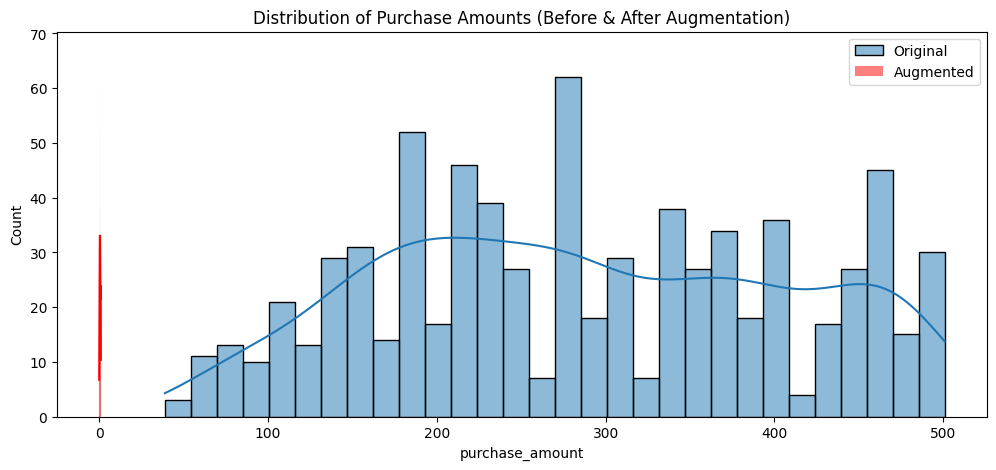

In [ ]:
# visualize purchase amount distributions

plt.figure(figsize=(12, 5))
sns.histplot(final_merged_data['purchase_amount'], bins=30, kde=True, label='Original')
sns.histplot(final_merged_data['purchase_amount_aug'], bins=30, kde=True, color='red', label='Augmented')
plt.legend()
plt.title("Distribution of Purchase Amounts (Before & After Augmentation)")
plt.show()


### Feature Selection For ML

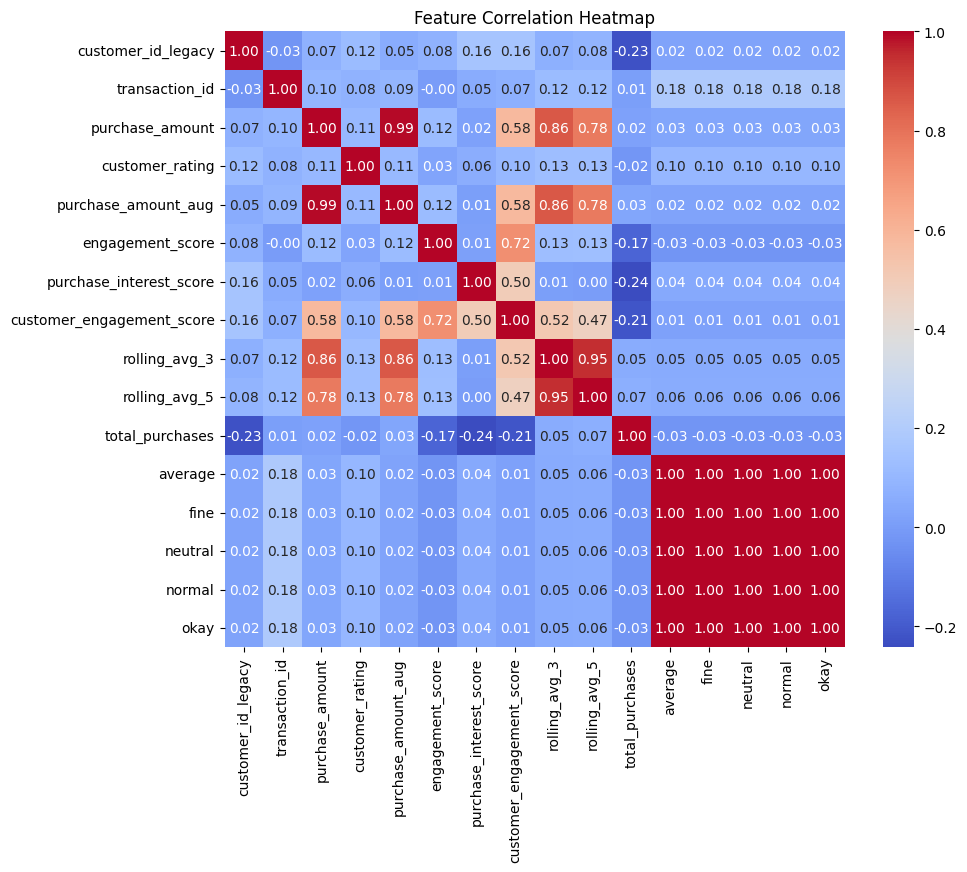

In [ ]:
# correlation heatmap

# select only numeric columns
numeric_data = final_merged_data.select_dtypes(include=['number'])

# plot
plt.figure(figsize=(10,8))
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()



In [ ]:
# Select the top 10 most important features

# Encode categorical target
le = LabelEncoder()
final_merged_data['review_sentiment_encoded'] = le.fit_transform(final_merged_data['review_sentiment'])

# Select numeric features
features = final_merged_data.select_dtypes(include=['number']).drop(columns=['review_sentiment_encoded'])
target = final_merged_data['review_sentiment_encoded']

# Feature importance using Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(features, target)
feature_importances = pd.DataFrame({'Feature': features.columns, 'Importance': rf.feature_importances_})
top_features = feature_importances.sort_values(by='Importance', ascending=False).head(10)
print("Top 10 Features:\n", top_features)


Top 10 Features:
                       Feature  Importance
5            engagement_score    0.260437
6     purchase_interest_score    0.190517
10            total_purchases    0.116996
7   customer_engagement_score    0.108462
0          customer_id_legacy    0.083602
3             customer_rating    0.047305
9               rolling_avg_5    0.041125
4         purchase_amount_aug    0.039543
8               rolling_avg_3    0.039458
2             purchase_amount    0.036637


In [ ]:
# save final dataset
final_merged_data.to_csv("final_dataset_ready_pld14.csv", index=False)
print("Final dataset saved successfully!")


Final dataset saved successfully!
